In [1]:
using Clustering, PyPlot
using TextAnalysis
using JLD2
using Statistics
using XLSX
using CSV
using DataFrames
using Dates
using LinearAlgebra
using StatsBase
using MultivariateStats
using Random

In [97]:
include("../src/utill.jl")

sel_top (generic function with 1 method)

In [3]:
new_df = XLSX.readxlsx("../data/Data-Spring/covid-ru.xlsx")["Sheet1"]
stop_ind = new_df.dimension.stop;

en_1 = DataFrame(new_df["A2:$stop_ind"],  [:retweet_count, :favorite_count, 
        :created_at, :text, :id_str, 
        :lang])
mask_tmp = ones(Bool, length(en_1.id_str)) 
insert!(en_1, 7, mask_tmp, :tind)


new_df = XLSX.readxlsx("../data/Data-Winter/covid-ru.xlsx")["Sheet1"]
stop_ind = new_df.dimension.stop;

en_2 = DataFrame(new_df["A2:$stop_ind"],  [:retweet_count, :favorite_count, 
        :created_at, :text, :id_str, 
        :lang]);

mask_tmp = zeros(Bool, length(en_2.id_str)) 
insert!(en_2, 7, mask_tmp, :tind)

min_dim = minimum([length(en_1.tind), length(en_2.tind)])

df = append!(en_1[1:min_dim, :], en_2[1:min_dim, :]);

# df = df[shuffle(1:length(df.favorite_count)), :]

## Preprocessing:

In [4]:
function preprocess_corp(data)
    data_preprocessed = replace.(data, r"http\S+" => s"")
    data_preprocessed = replace.(data_preprocessed, r"\S+.com" => s"")
    data_preprocessed = replace.(data_preprocessed, r"resulting" => s"")
    data_preprocessed = replace.(data_preprocessed, r"RESULTING" => s"")
    data_preprocessed = replace.(data_preprocessed, r"#resulting" => s"")
    data_preprocessed = replace.(data_preprocessed, r"@\S+" => s"")
    data_preprocessed = replace.(data_preprocessed, r"&amp" => s"")
    data_preprocessed = replace.(data_preprocessed, r"RT\S+" => s"");

    crps_tmp = Corpus(StringDocument.(deepcopy(data_preprocessed)));

    remove_case!(crps_tmp)
    prepare!(crps_tmp, strip_punctuation)
    prepare!(crps_tmp, strip_numbers)
    prepare!(crps_tmp, strip_articles)

#     prepare!(crps_tmp, strip_stopwords)
    remove_words!(crps_tmp, ["covid", "коронавирус", "коронавируса", "коронавирусом", "новых", "случаев", "сутки", "coronavirus", 
            "области", "число", "человек", "россии", "пациентов", "новости", "более", "после", "всего", "против", "апреля", "может", "тысяч", "будет", "пандемии", "декабря", "коронавирусной",  "подробнее", "украине",
            "выявили", "выявлено", "которые", "только", "случая", "через", "случаи", "будут", "последние", "время", "сегодня", "больше", "борьбе"])
    stem!(crps_tmp)
    prepare!(crps_tmp, strip_whitespace)
    update_lexicon!(crps_tmp)
    return crps_tmp
end

preprocess_corp (generic function with 1 method)

In [27]:
crps = preprocess_corp(df[:,4])

A Corpus with 25744 documents:
 * 25744 StringDocument's
 * 0 FileDocument's
 * 0 TokenDocument's
 * 0 NGramDocument's

Corpus's lexicon contains 48023 tokens
Corpus's index contains 0 tokens

In [28]:
# crps_1 = preprocess_corp(df[df.tind,4])
# crps_2 = preprocess_corp(df[.!df.tind,4]);

In [29]:
# Create a vector from merged corpus: 

lexicone_vect = lexicon(crps)

n_max = 300
pairs = sort(collect(lexicone_vect), by=x->x[2], rev=true)[1:n_max]
terms = [i[1] for i in pairs]

terms_mask = [length(term)>4 for term in terms]
terms = terms[terms_mask];

In [30]:
terms[1:25]

25-element Array{String,1}:
 "вакцины"
 "заражения"
 "заболевших"
 "москве"
 "больных"
 "заболевания"
 "количество"
 "умерли"
 "человека"
 "карантин"
 "инфекции"
 "новый"
 "людей"
 "вакцину"
 "вакцинации"
 "беларуси"
 "заявил"
 "данные"
 "распространения"
 "рассказал"
 "когда"
 "ученые"
 "здравоохранения"
 "борьбы"
 "могут"

In [31]:
# # Create a vector from different datasets: 

# lexicone_vect_1 = lexicon(crps_1)
# lexicone_vect_2 = lexicon(crps_2)

# n_max = 200
# pairs_1 = sort(collect(lexicone_vect_1), by=x->x[2], rev=true)[1:n_max]
# terms_1 = [i[1] for i in pairs_1]

# pairs_2 = sort(collect(lexicone_vect_2), by=x->x[2], rev=true)[1:n_max]
# terms_2 = [i[1] for i in pairs_2]

# terms = unique([terms_1 ; terms_2])

# length(terms)

In [75]:
m = DocumentTermMatrix(crps, terms)

A 25744 X 184 DocumentTermMatrix

In [76]:
D = convert.(Float64, dtm(m, :dense)')

# D[:,df.tind] = D[:,df.tind] ./ sum(D[:,df.tind])
# D[:,.!df.tind] = D[:,.!df.tind] ./ sum(D[:,.!df.tind]);

In [77]:
# PCA:

M = fit(PCA, D; maxoutdim=5)
Yte = MultivariateStats.transform(M, D)

5×25744 Array{Float64,2}:
 -0.0211538    -0.0242657   …   0.11632     -0.0460377   0.0569718
  0.0916814     0.0780754      -0.00388741   0.0700516   0.034423
 -0.000910245   0.00991395     -0.00996763   0.0254502  -0.0223529
  0.0251832     0.0447865      -0.479234     0.0112461  -0.215297
 -0.0360118    -0.0067325      -0.168889     0.0441054  -0.405903

In [78]:
# Independent Component Analysis:

# M = fit(ICA, D, 6)
# Yte = MultivariateStats.transform(M, D)

In [79]:
n_clusters = 5
cl = kmeans(Yte, n_clusters);
cl_assignments = cl.assignments;

In [80]:
# vars = (Yte, cl_assignments, M, D)
# JLD2.@save "../data/tmp_files/ru.jld" vars

In [81]:
JLD2.@load "../data/tmp_files/ru.jld" vars
(Yte, cl_assignments, M, D) = vars ;

In [82]:
cvals= log.(1 .+ df.favorite_count)
avals = 1 .+ df.retweet_count ; avals = log.(avals); avals = avals .- (minimum(avals) - 0.1) ; avals = avals ./ maximum(avals)
avals_t = [df.tind[i] == 1 ? plt.cm.Blues_r(avals[i]) : plt.cm.Reds_r(avals[i]) for i in eachindex(df.tind)];

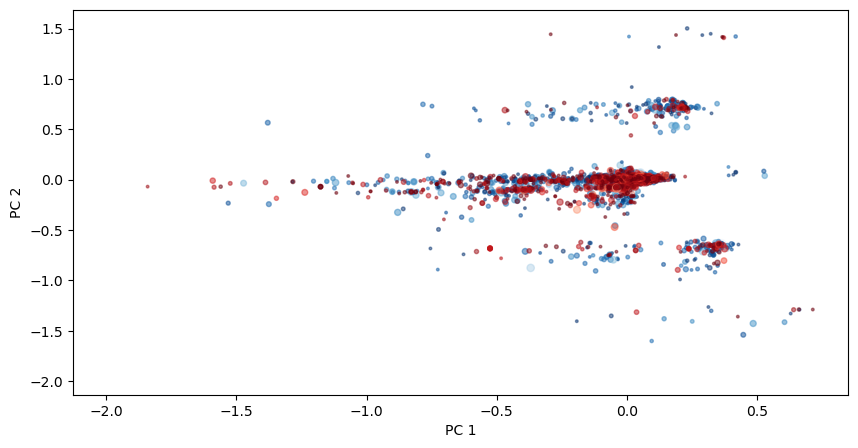

In [83]:
fig, ax= plt.subplots(1,1, figsize=(10,5))

ax.scatter(Yte[4,:], Yte[3,:], alpha=0.5, s=5.0.*cvals, c=avals_t, rasterized=true, label="April")

# ax.set_xlim(-1, 7)
# ax.set_ylim(-1, 7)

# ax.legend(loc="lower right", frameon=false ) # 

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

# ax.set_xticks([])
# ax.set_yticks([]);

# ax.set_xticklabels([])
# ax.set_yticklabels([]);

# ax.set_axis_off()

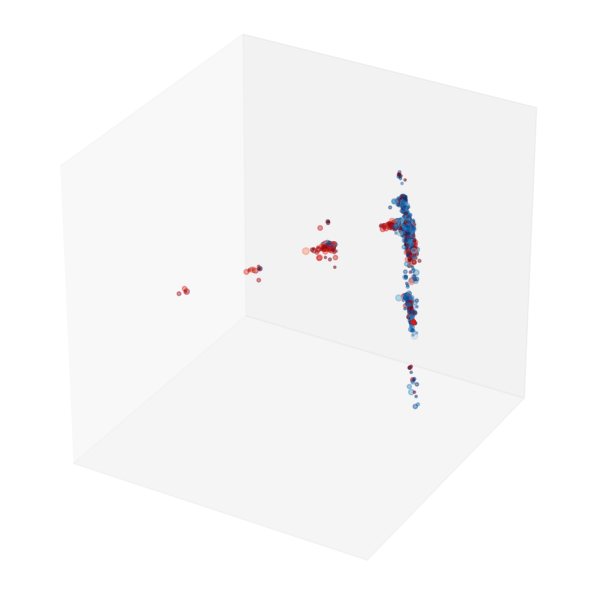

In [84]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection="3d")

ax.scatter(Yte[1,:], Yte[2,:], Yte[3,:],  alpha=0.4, s=4.0.*cvals, c=avals_t, rasterized=true, label="April") 

# ax.set_xlabel("PC 1")
# ax.set_ylabel("PC 2")
# ax.set_zlabel("PC 3")

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([]);

# ax.set_xlim(0.2, 7)
# ax.set_ylim(-0, 7)
# ax.set_zlim(-3.5, 0)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# ax.w_xaxis.gridlines.set_lw(0.5)
# ax.w_yaxis.gridlines.set_lw(0.5)
# ax.w_zaxis.gridlines.set_lw(0.5)

# ax.view_init(elev=10.,) # azim=-10

ax.set_box_aspect((1, 1, 1))
# ax.set_axis_off()

fig.tight_layout()

# fig.savefig("../plots/3d-samples-de.pdf", bbox_inches = "tight", dpi=800)

In [85]:
# fig, ax = plt.subplots(1,1, figsize=(7,5))

# clst_tmp = unique(cl_assignments)

# for (ind, val) in enumerate(clst_tmp)
#     cl_mask = cl_assignments .== val
#     ax.scatter(Yte[1,cl_mask], Yte[2,cl_mask], s=3, color=plt.cm.hsv(ind/length(clst_tmp)), alpha=0.8, ) 
# end

# ax.set_xlabel("PC 1")
# ax.set_ylabel("PC 2")

# ax.set_xticklabels([])
# ax.set_yticklabels([]);

# # ax.set_axis_off()

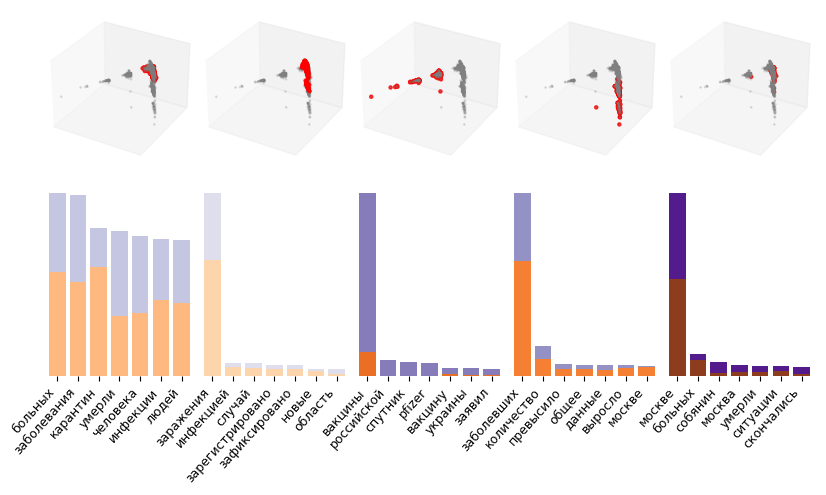

In [86]:
# Oranges - Begining 
# Purples - End

figure = make_plots(Yte, D, terms, cl_assignments, df.tind, df.favorite_count, ); #size=(15,15)

In [93]:
# figure.savefig("../plots/words-clusters-ru.pdf", bbox_inches = "tight")

In [98]:
sorted_top = sel_top(df, cl_assignments)

,clust_id,favorite_count,created_at,text
,Int64,Any,Any,Any
1,1,2425,2020-04-12T21:07:30,"Из шести пациентов — четыре covid-19+ пневмоний. Все возрастные и с приличным багажом хронических заболеваний. На ИВЛ никого нет, гемодинамически все стабильны. \n\nСводки с полей, чтобы не было заблуждений, будто тут какой-то апокалипсис, а я хайпую."
2,1,1710,2020-04-11T08:07:22,"Дональд Трамп подписал меморандум помощи Италии в борьбе с COVID-19. Значит лет через пятнадцать американцы будут рассказывать всему миру, как они победили эпидемию в Италии. Тот же самый алгоритм, что и со Второй Мировой войной."
3,1,1556,2020-04-13T12:53:32,"Ну всё, чёртов covid-19 добрался и до видеоигр \nЭтот парень ходил в качалку во время эпидемии https://t.co/webxI4HodD"
4,1,1496,2020-04-13T10:51:20,Забирают ребенка с Covid-19. https://t.co/4SM31vNiKw
5,1,1127,2020-04-11T08:19:42,Мой covid-19 тест пришёл отрицательный)
6,1,1034,2020-04-14T08:51:39,"""СК проверит на халатность руководство больницы в Уфе, где 170 человек заболели COVID-19""\nГде эти 170 человек в статистике - никто не объясняет. https://t.co/06tIGkdALQ"
7,1,832,2020-04-11T18:56:42,Непробиваемый. Лидер. https://t.co/obzSNp4Bsy
8,1,814,2020-04-13T16:05:55,В Китае назвали Россию главным источником завоза Covid-19 https://t.co/o55E2bYFrg
9,1,562,2020-04-13T13:53:51,"В Белоруссии умерли 29 пациентов с COVID-19. Лукашенко заявил, что ни одну из смертей не вызвал коронавирус \n\nhttps://t.co/3NBMYyyS1H"


In [100]:
# XLSX.writetable("../data/upload/Data-Clusters-Equal/sorted-ru.xlsx", collect(DataFrames.eachcol(sorted_top)), DataFrames.names(sorted_top))